# Temporal And Spatial Analysis of Downtown Homeless Sleepers

This notebook is an example of temporal and spatial analysis of homeless sleepers in downtown San Diego. 


In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mapclassify
from IPython.display import display, HTML

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
#pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-dowtown_homeless-9.zip')

pkg

# Downtown San Diego Homeless Sleepers
`sandiegodata.org-dowtown_homeless-9` Last Update: 2019-10-03T18:22:47

_Five years of monthly geographic positions for homeless sleepers in Downtown San Diego_


This dataset provides geographic locations for homeless sleepers in Downtown San Diego, as counted by enumerators from the Downtown San Diego Partnership. These counts have been done monthly since 2012, and this dataset provides counts since 2014. 

<center><a
href="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless
-Sleepers.png"><img
src="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless-
Sleepers.png" width="400px"></a></center>


The count is done on paper maps with handwritten count marks. The San Diego
Regional Data Library's [Downton Homelessness
project](http://downtown-homelessness.sandiegodata.org/) converted these
scanned count maps using a [web based image annotation
tool](http://www.robots.ox.ac.uk/~vgg/software/via/).

## Base and Imputed Datasets

This distribution has two version of the homeless counts, the base set,
``homeless_counts``, which has three months of missing data, and the imputed
dataset, ``imputed_counts`` in which these three missing months, 2014-08,
2014-09, and 2015-06 are probabilistically re-created.

The Imputation process uses the total count for the month, from the
``monthly_totals`` dataset, as the number of sleepers that the imputed month
will have. Then, the imputation process collects at least 1,000 records with
dates near the missing month into a sample set, calculating the portion of
records that are in each census block. Then the algorithm randomly selects that
number of records for each census block, and adjusts random blocks so the total
of the whole set of selected records is equal to the official count for the
month.

The result is an imputed month that has the same number of records as the
official count for the month and as the same portion of sleepers in each census
block as in adjacent months.

## Notes

Notes for the source dataset, as of April 2019:

The preliminary methodology (shown in yellow) [ March 2017 and earlier] counted
two individuals per tent and two individuals per vehicle.

On April 27, 2017, the Clean & Safe program adopted the counting methodology
used by the Regional Task Force on the Homeless. Per the methodology
(represented above by the dark green cells), [April 2017 to April 2018,
inclusive ] Clean & Safe staff counted 1.75 individuals per visible
tent/structure and 1.66 individuals per vehicle that showed clear signs of
habitation.

In May 2018, the Regional Task Force on the Homeless updated the methodology
for vehicles to 2.03 that shows clear signs of habitation (the methodology of
1.75 individuals per tent/structure remained the same). The Clean & Safe
program implemented this methodology on May 31, 2018 (represented in orange).

\* Denotes the months that The Downtown Fellowship of Ministries and Churches collaborated with us on the monthly homeless sleep count.

\*\*East Village breakout areas include the following:
    * North East East Village is the area north of Market Street & east of Park Ave. 
    * North West is the area north of Market Street & west of Park Ave.
    * South East is the area east of Park Ave. south of Market Street
    * South West is the area west of Park Ave. south of Market Street

## Caveats

Because this data is extracted, manually, from manually recorded maps, there
are a lot of quality issues. 

### Missing Months

Because of conversion errors and some complications with the source maps, there
are several months of data that are excluded from this dataset

* **August 2014**. In the original datasets, August 2014 was a duplicate of September 2014. 
* **September 2014**. Comfusion related to the duplication of September and August resulted in September being incompletely processed. 
* **June 2015**. All of the map images for this month were blank. An alternate source PDF

In [3]:
mt = pkg.resource('monthly_totals').dataframe()
hc = pkg.resource('homeless_counts').dataframe()
hc['records'] = 1

ic = pkg.resource('imputed_counts').geoframe()
ic['records'] = 1

# Time Series

There are two datasets in the data package. The first has three missing months, which you can see as dips in the time series. The second has these missing months imputed. Also note that the official statistics, the blue line, cover a longer time period that the counts from this dataset. However, the official stats do not include geographic positions. 

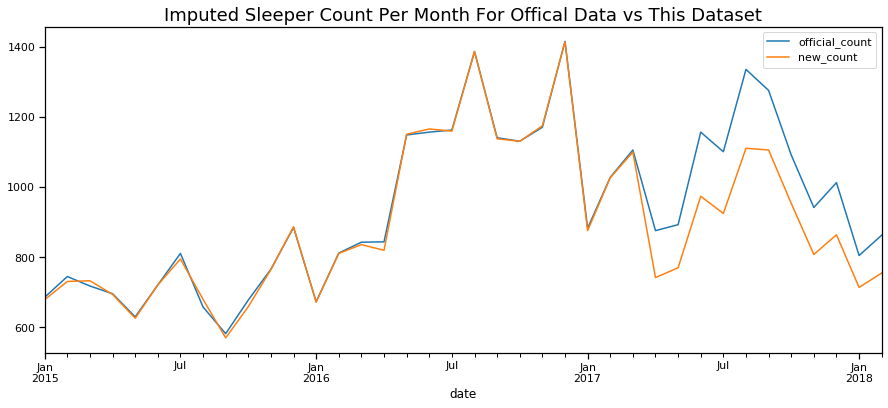

In [10]:

t = ic.set_index('date').groupby(pd.Grouper(freq="MS")).records.count().to_frame().rename(columns={'records':'new_count'})
mt = pkg.resource('monthly_totals').dataframe().set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'count':'official_count'})

j = mt.join(t)
ax = j.loc['2015':'2018-02-01'].plot(figsize=(15,6))
ax.set_title('Imputed Sleeper Count Per Month For Offical Data vs This Dataset', fontsize=18);
df = t

,new_count
date,
2014-01-01,430
2014-02-01,536
2014-03-01,633
2014-04-01,582
2014-05-01,597


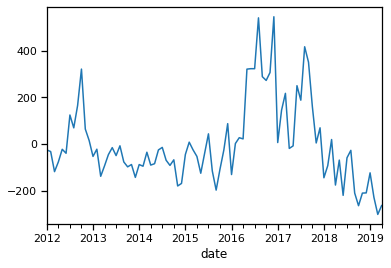

In [6]:
from statsmodels.tsa.tsatools import detrend
detrend(j['official_count']).plot()

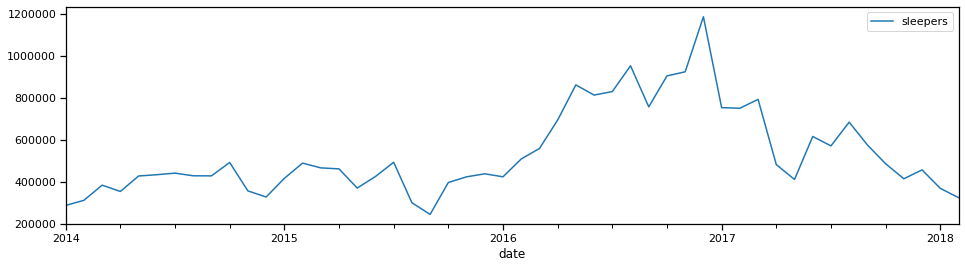

In [14]:
t = gpd.GeoDataFrame(ic[['geoid']].merge(ic, on='geoid'), geometry='geometry')
hl_ts = t[['records','date']].set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'records':'sleepers'})
ax = hl_ts.plot(figsize=(16, 4))


In [16]:
mt.head()

,official_count
date,
2012-01-01,486
2012-02-01,485
2012-03-01,405
2012-04-01,453
2012-05-01,513


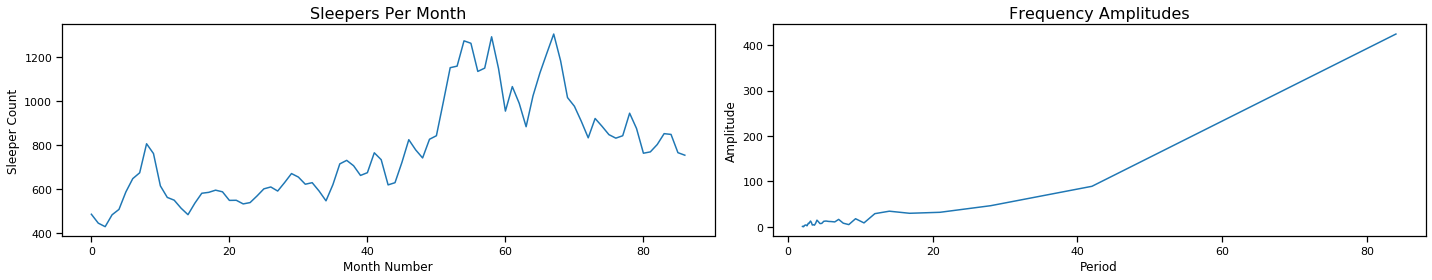

,freq,fft,amp
period,,,
42.0,0.023810,-896.364248-3771.718675j,89.121105
3.0,3.107143,-157.833004+128.393345j,60.540777
4.0,1.535714,259.202207-79.061664j,48.332538
28.0,0.035714,1952.225946+509.763444j,46.383519
14.0,0.071429,-283.506151+1464.163137j,34.284098
6.0,0.500000,232.641643+195.249265j,33.897415
5.0,0.607143,-304.836291+175.297624j,32.152404
21.0,0.047619,-1380.124019+127.796021j,31.862717
17.0,0.059524,1027.233897-782.866114j,29.690693


In [18]:
t = mt.rolling(2).mean().dropna().copy()
x = t.reset_index().index.values
y = t.official_count.values

def fft(s, N=None, T=1):

    import scipy.fftpack
    from scipy.signal.windows import hann
    
    if N is None:
        N = len(s)
    
    s = s * hann(len(s))
    
    yf = scipy.fftpack.fft(s)[:N//2]
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    amp = 2.0/N * np.abs(yf)
    
    df =   pd.DataFrame({'freq':xf, 'fft': yf, 'amp':amp})
    df['period'] = df.freq.rtruediv(1.0).replace([np.inf, -np.inf], np.nan)
    
    return df

f = fft(y)

def plot_fft(x,y,f):

    fig, ax = plt.subplots(1,2, figsize=(20,4))
    ax = ax.flat

    #fig.suptitle('FFT Analysis', fontsize=22)
    ax[0].plot(x,y)
    ax[0].set_xlabel("Month Number")
    ax[0].set_ylabel("Sleeper Count")
    ax[0].set_title('Sleepers Per Month', fontsize=16)

    #ax[1].set_xlim(0,10)
    #ax[1].set_ylim(0,80)
    ax[1].plot(f.period, f.amp )
    ax[1].set_xlabel("Period")
    ax[1].set_ylabel("Amplitude")
    ax[1].set_title('Frequency Amplitudes', fontsize=16)

    plt.tight_layout()

    plt.show()

def sort_amp(y, f):
    t = f[f.period < len(y)/2].dropna().copy()
    t['period'] = f.period.round()
    t = t.groupby('period').sum().sort_values('amp', ascending=False)
    return t

plot_fft(x,y,f)
    
display(HTML("<h2>Highest Apmplitude Periods"))


display(sort_amp(y, f).head(10))